## Importing necessary dependencies and libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

## Data loading and prprocessing

In [ ]:
data = pd.read_csv('stock.csv', index_col = 'Date')
data = data.iloc[:, :]
data

,Open,High,Low,Close,Adj Close,Volume,pct_change,log_change,SMA_07,SMA_14,...,BB_LOWER,BB_MIDDLE,BB_UPPER,RSV_14,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-26,122.900002,123.099998,120.703003,121.093002,121.093002,71364000,-0.006164,-0.006183,122.062787,120.392822,...,113.909932,119.476525,125.043119,48.131974,147.335972,140.683243,139.998095,136.093582,133.031545,133.392025
2020-05-27,120.249496,120.679001,116.500000,120.519501,120.519501,101138000,-0.004736,-0.004747,122.067144,120.604001,...,114.413882,119.717300,125.020718,37.903358,147.471658,140.903212,140.117815,134.458143,127.761801,127.145829
2020-05-28,119.216499,121.848503,118.911499,120.055000,120.055000,63804000,-0.003854,-0.003862,121.887429,120.723608,...,114.506719,119.788276,125.069832,31.314232,147.605922,141.126894,140.243517,132.884647,123.760151,122.381789
2020-05-29,120.796997,122.118500,119.910004,122.118500,122.118500,70198000,0.017188,0.017042,121.837715,120.947751,...,114.620438,119.709201,124.797963,60.585806,147.738772,141.354208,140.375545,131.402958,121.323848,119.651524
2020-06-01,122.400002,123.846497,122.208504,123.552002,123.552002,58578000,0.011739,0.011670,121.645572,121.169322,...,115.465774,120.171701,124.877627,80.920614,147.870217,141.585073,140.514229,130.041813,120.461870,119.059476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100,-0.002730,-0.002734,152.089999,149.467142,...,142.461283,148.578999,154.696716,93.193624,146.635991,139.641591,139.476493,144.163260,156.576827,156.482027
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200,-0.000065,-0.000065,152.945714,149.933571,...,142.411071,148.863000,155.314929,93.088969,146.778883,139.841941,139.571794,142.657127,154.284491,155.165034
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700,-0.000456,-0.000456,153.427141,150.563570,...,142.502726,149.178500,155.854273,91.075669,146.920321,140.046344,139.671225,141.070728,150.311402,151.853787


In [ ]:
data['y'] = data['Close']

x = data.iloc[:, :26].values
y = data.iloc[:, 26].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (725, 26) trainY: (725,)
testX: (182, 26) testY: (182,)


## VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [ ]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([26, 400, 400, 400, 10], 10)

[1/300] Loss: 156.23340225219727
[2/300] Loss: 148.78259086608887
[3/300] Loss: 142.71575927734375
[4/300] Loss: 137.2979679107666
[5/300] Loss: 131.8620147705078
[6/300] Loss: 126.57030868530273
[7/300] Loss: 121.58387851715088
[8/300] Loss: 117.09460926055908
[9/300] Loss: 113.29669857025146
[10/300] Loss: 110.48183059692383
[11/300] Loss: 109.06982803344727
[12/300] Loss: 109.27734851837158
[13/300] Loss: 110.68911075592041
[14/300] Loss: 112.91369342803955
[15/300] Loss: 115.41286563873291
[16/300] Loss: 117.43393898010254
[17/300] Loss: 118.16712188720703
[18/300] Loss: 117.08921432495117
[19/300] Loss: 114.19829654693604
[20/300] Loss: 110.11084461212158
[21/300] Loss: 105.69285869598389
[22/300] Loss: 101.78665065765381
[23/300] Loss: 98.93467712402344
[24/300] Loss: 97.3558406829834
[25/300] Loss: 96.91709899902344
[26/300] Loss: 97.33931732177734
[27/300] Loss: 98.23680114746094
[28/300] Loss: 99.26116752624512
[29/300] Loss: 100.17586135864258
[30/300] Loss: 100.7845764160156

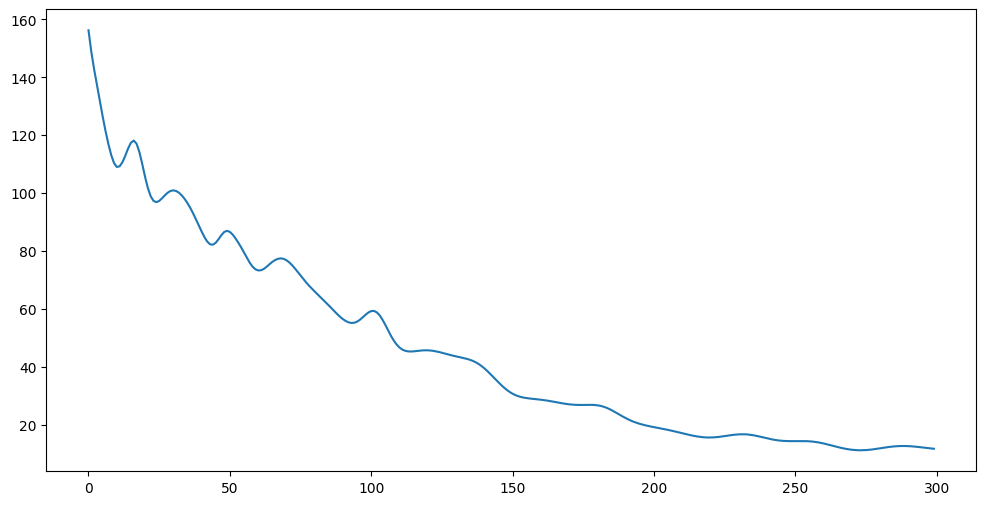

In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [ ]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [ ]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [ ]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [ ]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([722, 3, 36]) train_y: torch.Size([722, 1]) train_y_gan: torch.Size([722, 4, 1])
test_x: torch.Size([179, 3, 36]) test_y: torch.Size([179, 1]) test_y_gan: torch.Size([179, 4, 1])


## GRU Model

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

In [ ]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000164
num_epochs = 50

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)

model = Generator(36).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss_ = []
    y_pred = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
        y_train_pred = model(x)
        loss = criterion(y_train_pred, y)
        loss_.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))



[1/50] Loss: 1.5444022938609123
[2/50] Loss: 0.5285383705049753
[3/50] Loss: 0.21529095899313688
[4/50] Loss: 0.08855840028263628
[5/50] Loss: 0.13643438834697008
[6/50] Loss: 0.08127290941774845
[7/50] Loss: 0.05971114104613662
[8/50] Loss: 0.04823254095390439
[9/50] Loss: 0.037127402145415545
[10/50] Loss: 0.029715464217588305
[11/50] Loss: 0.027214011061005294
[12/50] Loss: 0.023370082140900195
[13/50] Loss: 0.019887853763066232
[14/50] Loss: 0.021215787157416344
[15/50] Loss: 0.019634367257822305
[16/50] Loss: 0.018412262899801135
[17/50] Loss: 0.018807951651979238
[18/50] Loss: 0.018430263793561608
[19/50] Loss: 0.019672303926199675
[20/50] Loss: 0.02181510115042329
[21/50] Loss: 0.022041450545657426
[22/50] Loss: 0.024905526894144714
[23/50] Loss: 0.02808192151132971
[24/50] Loss: 0.036877446109429
[25/50] Loss: 0.034950134926475585
[26/50] Loss: 0.0455686051864177
[27/50] Loss: 0.035316778579726815
[28/50] Loss: 0.03581545426277444
[29/50] Loss: 0.023427296488080174
[30/50] Loss

Text(0.5, 0, 'Days')

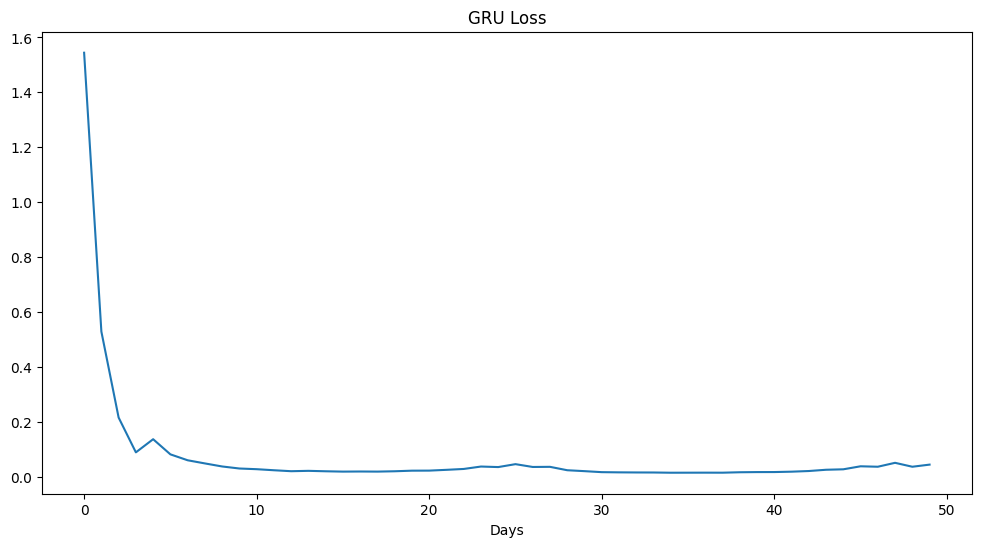

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(hist, label = 'Loss')
plt.title('GRU Loss')
plt.xlabel('Days')


In [ ]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

In [ ]:
data.reset_index(drop=False, inplace=True)



([<matplotlib.axis.XTick at 0x7a7431db6e60>,
 [Text(18408.0, 0, 'May 2020'),
  Text(18414.0, 0, 'Jun 2020'),
  Text(18444.0, 0, 'Jul 2020'),
  Text(18477.0, 0, 'Aug 2020'),
  Text(18506.0, 0, 'Sep 2020'),
  Text(18536.0, 0, 'Oct 2020'),
  Text(18568.0, 0, 'Nov 2020'),
  Text(18597.0, 0, 'Dec 2020'),
  Text(18631.0, 0, 'Jan 2021'),
  Text(18659.0, 0, 'Feb 2021'),
  Text(18687.0, 0, 'Mar 2021'),
  Text(18718.0, 0, 'Apr 2021'),
  Text(18750.0, 0, 'May 2021'),
  Text(18779.0, 0, 'Jun 2021'),
  Text(18809.0, 0, 'Jul 2021'),
  Text(18841.0, 0, 'Aug 2021'),
  Text(18871.0, 0, 'Sep 2021'),
  Text(18901.0, 0, 'Oct 2021'),
  Text(18932.0, 0, 'Nov 2021'),
  Text(18962.0, 0, 'Dec 2021'),
  Text(18995.0, 0, 'Jan 2022'),
  Text(19024.0, 0, 'Feb 2022'),
  Text(19052.0, 0, 'Mar 2022'),
  Text(19083.0, 0, 'Apr 2022'),
  Text(19114.0, 0, 'May 2022'),
  Text(19144.0, 0, 'Jun 2022'),
  Text(19174.0, 0, 'Jul 2022'),
  Text(19205.0, 0, 'Aug 2022'),
  Text(19236.0, 0, 'Sep 2022'),
  Text(19268.0, 0, 'Oct 202

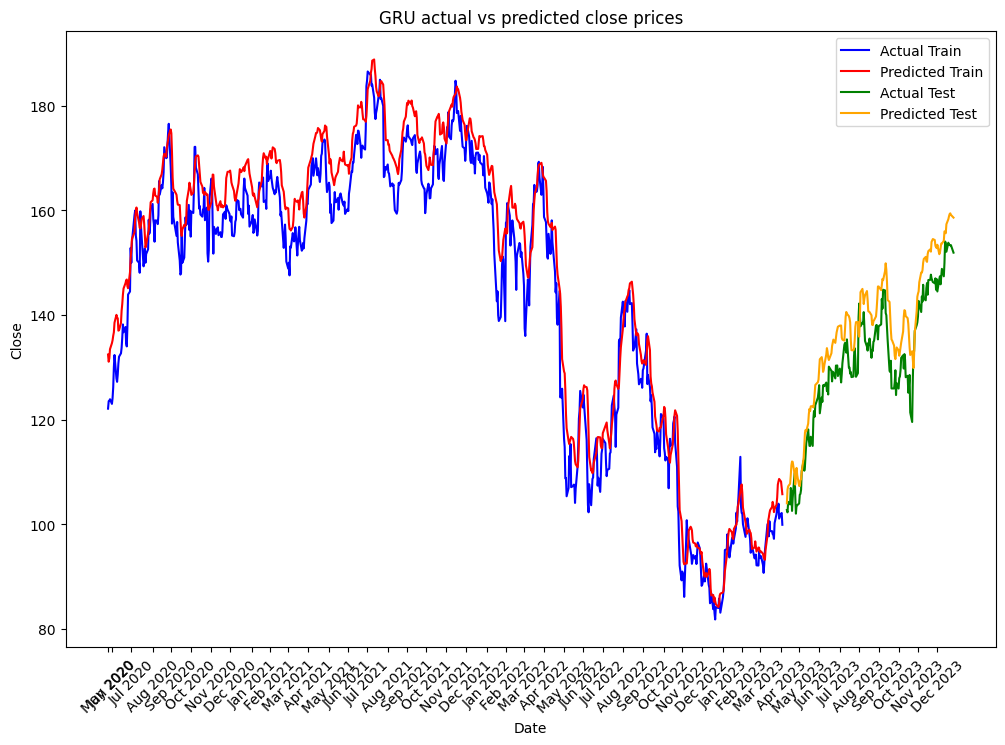

In [ ]:
plt.figure(figsize=(12, 8))
data['Date'] = pd.to_datetime(data['Date'])

# Extract month from the 'Date' column
data['Month'] = data['Date'].dt.month

# Find the indices where the month changes
month_changes = np.where(data['Month'].diff() != 0)[0]

plt.plot(data['Date'][:len(y_train_true)], y_train_true, label='Actual Train', color='blue')
plt.plot(data['Date'][:len(y_train_pred)], y_train_pred, label='Predicted Train', color='red')

plt.plot(data['Date'][split:(split + len(y_test_true))], y_test_true, label='Actual Test', color='green')
plt.plot(data['Date'][split:(split + len(y_test_pred))], y_test_pred, label='Predicted Test', color='orange')

plt.title('GRU actual vs predicted close prices')
plt.ylabel('Close')
plt.xlabel('Date')
plt.legend(loc = 'upper right')

plt.xticks(data['Date'][month_changes], data['Date'].dt.strftime('%b %Y')[month_changes], rotation=45)


## Performance Metric

In [ ]:
MSE1 = mean_squared_error(y_train_true, y_train_pred)
RMSE1 = math.sqrt(MSE1)
print(f'Training dataset MSE:{MSE1}')
print(f'Training dataset RMSE:{RMSE1}')
MSE2 = mean_squared_error(y_test_true, y_test_pred)
RMSE2 = math.sqrt(MSE2)
print(f'Testing dataset MSE:{MSE2}')
print(f'Testing dataset RMSE:{RMSE2}')

Training dataset MSE:39.755825678002125
Training dataset RMSE:6.30522209585056
Testing dataset MSE:40.65506751196436
Testing dataset RMSE:6.376132645417939
